Image Segmentation of Handwritten Digits

<img src='https://drive.google.com/uc?export=view&id=1-WBX7w_R9abwdGmAUBFWWEcJ0LkMppq2' alt='m2nist digits'>

We will build a model that predicts the segmentation masks (pixel-wise label map) of handwritten digits. This model will be trained on the [M2NIST dataset](https://www.kaggle.com/farhanhubble/multimnistm2nist), a multi digit MNIST.

Will be building a Convolutional Neural Network (CNN) from scratch for the downsampling path and use a Fully Convolutional Network, FCN-8, to upsample and produce the pixel-wise label map. The model will be evaluated using the intersection over union (IOU) and Dice Score. 

## Imports

In [1]:
import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


## Download the dataset

[M2NIST](https://www.kaggle.com/farhanhubble/multimnistm2nist) is a **multi digit** [MNIST](http://yann.lecun.com/exdb/mnist/). 
Each image has up to 3 digits from MNIST digits and the corresponding labels file has the segmentation masks.

The dataset is available on [Kaggle](https://www.kaggle.com) and you can find it [here](https://www.kaggle.com/farhanhubble/multimnistm2nist)

In [2]:
# download zipped dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip \
    -O /tmp/m2nist.zip

# find and extract to a local folder ('/tmp/training')
local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2023-04-17 17:36:00--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  9.59MB/s    in 1.7s    

2023-04-17 17:36:02 (9.59 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



## Load and Preprocess the Dataset

This dataset can be easily preprocessed since it is available as **Numpy Array Files (.npy)**

1. **combined.npy** has the image files containing the multiple MNIST digits. Each image is of size **64 x 84** (height x width, in pixels).

2. **segmented.npy** has the corresponding segmentation masks. Each segmentation mask is also of size **64 x 84**.

This dataset has **5000** samples and you can make appropriate training, validation, and test splits as required for the problem.

With that, let's define a few utility functions for loading and preprocessing the dataset.

In [3]:
BATCH_SIZE = 32

def read_image_and_annotation(image, annotation):
  '''
  Casts the image and annotation to their expected data type and
  normalizes the input image so that each pixel is in the range [-1, 1]

  Args:
    image (numpy array) -- input image
    annotation (numpy array) -- ground truth label map

  Returns:
    preprocessed image-annotation pair
  '''

  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    images (list of strings) -- paths to each image file in the train set
    annos (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):
  '''
  Prepares batches of the validation set.
  
  Args:
    images (list of strings) -- paths to each image file in the val set
    annos (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):
  '''
  Prepares batches of the test set.
  
  Args:
    images (list of strings) -- paths to each image file in the test set
    annos (list of strings) -- paths to each label map in the test set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


def load_images_and_segments():
  '''
  Loads the images and segments as numpy arrays from npy files 
  and makes splits for training, validation and test datasets.

  Returns:
    3 tuples containing the train, val, and test splits
  '''

  #Loads images and segmentation masks.
  images = np.load('/tmp/training/combined.npy')
  segments = np.load('/tmp/training/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)


Load the preprocessed dataset and define the training, validation, and test sets.

In [4]:
# Load Dataset
train_slices, val_slices, test_slices = load_images_and_segments()

# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

## Let's Take a Look at the Dataset

Lets visually inspect the dataset before and after training. The utility functions above helps to show a few images as well as their annotations (i.e. labels).

In [5]:
# Visualization Utilities

# there are 11 classes in the dataset: one class for each digit (0 to 9) plus the background class
n_classes = 11

# assign a random color for each class
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps. Also overlays the metrics.

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the ground truth label map
    prediction (numpy array) -- the predicted label map
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each class
  '''

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) -- batch of images and annotations
    num_images (int) -- number of images to display
  '''
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


We can view a subset of the images from the dataset with the `list_show_annotation()` function defined above. Run the cells below to see the image on the left and its pixel-wise ground truth label map on the right.

<ipython-input-5-9f9d172ab684>:136: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


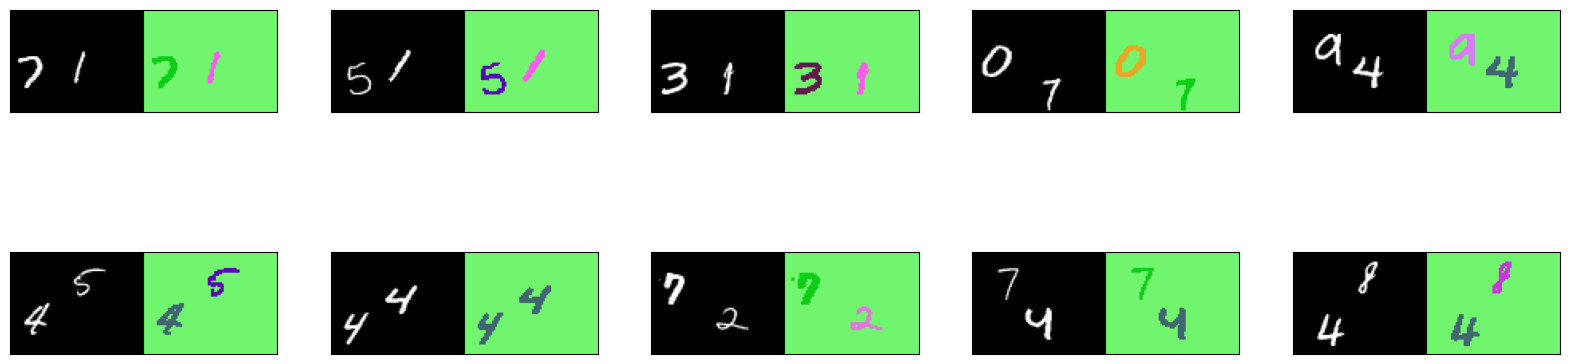

In [6]:
# get 10 images from the training set
list_show_annotation(training_dataset, 10)

<ipython-input-5-9f9d172ab684>:136: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


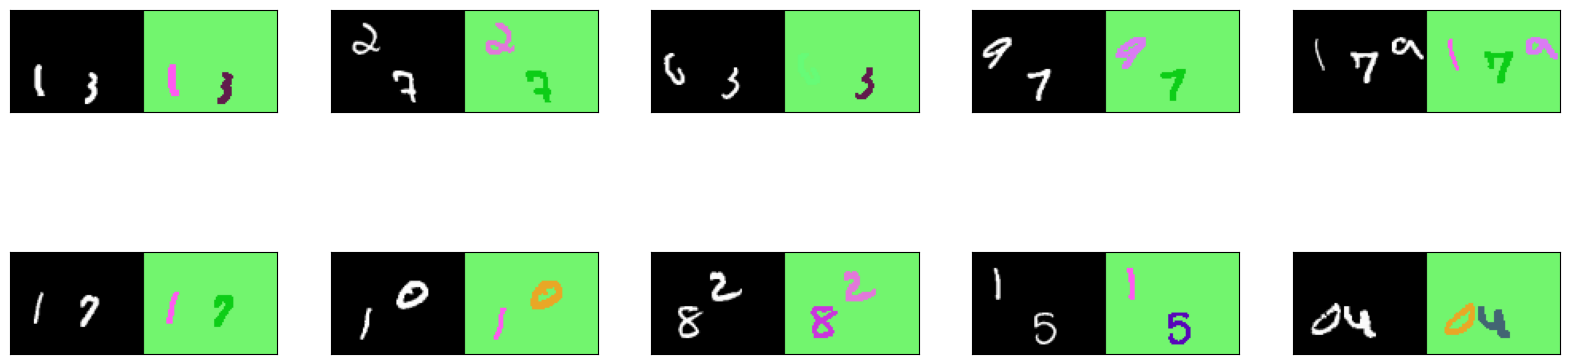

In [7]:
# get 10 images from the validation set
list_show_annotation(validation_dataset, 10)

## Define the Model

The image segmentation model will have two paths:

1. **Downsampling Path** - This part of the network extracts the features in the image. This is done through a series of convolution and pooling layers. The final output is a reduced image (because of the pooling layers) with the extracted features. You will build a custom CNN from scratch for this path.

2. **Upsampling Path** - This takes the output of the downsampling path and generates the predictions while also converting the image back to its original size. You will use an FCN-8 decoder for this path.

### Define the Basic Convolution Block


$$Input -> Conv2D -> LeakyReLU -> Conv2D -> LeakyReLU -> MaxPooling2D -> BatchNormalization$$


In [8]:
# parameter describing where the channel dimension is found in our dataset
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides):
  '''
  Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    kernel_size (int) -- kernel_size setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers
  
  Returns:
    (tensor) max pooled and batch-normalized features of the input 
  '''

  # use the functional syntax to stack the layers as shown in the diagram above
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size= pooling_size, strides= pool_strides)(x)
  x = tf.keras.layers.BatchNormalization()(x)


  return x

In [9]:
# TEST CODE:

test_input = tf.keras.layers.Input(shape=(64,84, 1))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

# free up test resources
del test_input, test_output, test_model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 84, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 84, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 84, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 84, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 84, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 42, 32)       0         
 )                                                               
                                                             

### Define the Downsampling Path

Now that we've defined the building block of our encoder, you can now build the downsampling path. This should chain together five convolution building blocks to create a feature extraction CNN minus the fully connected layers.


In [10]:
def FCN8(input_height=64, input_width=84):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''
   
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))


    
    # pad the input image width to 96 pixels
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96-input_width)))(img_input)
    
    # Block 1
    x = conv_block(x, 32, 2, 2, 2)
    
    # Block 2
    x = conv_block(x, 64, 2, 2, 2)

    # Block 3
    x = conv_block(x, 128, 2, 2, 2)
    # save the feature map at this stage
    f3 = x

    # Block 4
    x = conv_block(x, 256, 2, 2, 2)
    # save the feature map at this stage
    f4 = x

    # Block 5
    x = conv_block(x, 256, 2, 2, 2)
    # save the feature map at this stage
    f5 = x


  
    return (f3, f4, f5), img_input

In [11]:
# TEST CODE:

test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

print(test_model.summary())

del test_convs, test_img_input, test_model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 84, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 64, 96, 1)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 96, 32)        160       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 96, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 96, 32)        4128      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 96, 32)        0         
                                                           

### Define the FCN-8 decoder

<a name='exercise-3'></a>

#### **Exercise 3**

Now you can define the upsampling path taking the outputs of convolutions at each stage as arguments.
* Note: remember to set the `data_format` parameter for the Conv2D layers. 


<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8'>

In [12]:
def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)

    


  # Upsample `o` above and crop any extra pixels introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o =  (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2)))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 =  f3
  o2 = tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8))(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

  # append a sigmoid activation
  o = (tf.keras.layers.Activation('softmax'))(o)


  return o

In [13]:
# TEST CODE

test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 84, 11)


**Expected Output:**

```txt
(None, 64, 84, 11)
```

### Define the Complete Model

The downsampling and upsampling paths can now be combined as shown below.

In [14]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, n_classes)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

In [15]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 84, 1)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 64, 96, 1)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_25 (Conv2D)             (None, 64, 96, 32)   160         ['zero_padding2d_2[0][0]']       
                                                                                                  
 leaky_re_lu_22 (LeakyReLU)     (None, 64, 96, 32)   0           ['conv2d_25[0][0]']        

## Compile the Model

In [16]:

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])


## Model Training

In [17]:
EPOCHS = 250

steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE


history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/250
125/125 [==============================] - 21s 53ms/step - loss: 0.7255 - accuracy: 0.9029 - val_loss: 0.3740 - val_accuracy: 0.9430
Epoch 2/250
125/125 [==============================] - 6s 45ms/step - loss: 0.2758 - accuracy: 0.9424 - val_loss: 0.3274 - val_accuracy: 0.9430
Epoch 3/250
125/125 [==============================] - 5s 44ms/step - loss: 0.2519 - accuracy: 0.9424 - val_loss: 0.2938 - val_accuracy: 0.9430
Epoch 4/250
125/125 [==============================] - 6s 47ms/step - loss: 0.2406 - accuracy: 0.9424 - val_loss: 0.2585 - val_accuracy: 0.9430
Epoch 5/250
125/125 [==============================] - 5s 43ms/step - loss: 0.2350 - accuracy: 0.9424 - val_loss: 0.2375 - val_accuracy: 0.9430
Epoch 6/250
125/125 [==============================] - 7s 54ms/step - loss: 0.2312 - accuracy: 0.9424 - val_loss: 0.2295 - val_accuracy: 0.9430
Epoch 7/250
125/125 [==============================] - 5s 43ms/step - loss: 0.2282 - accuracy: 0.9424 - val_loss: 0.2258 - val_accuracy

**Expected Output:**

The losses should generally be decreasing and the accuracies should generally be increasing. For example, observing the first 4 epochs should output something similar:

```txt
Epoch 1/70
125/125 [==============================] - 6s 50ms/step - loss: 0.5542 - accuracy: 0.8635 - val_loss: 0.5335 - val_accuracy: 0.9427
Epoch 2/70
125/125 [==============================] - 6s 47ms/step - loss: 0.2315 - accuracy: 0.9425 - val_loss: 0.3362 - val_accuracy: 0.9427
Epoch 3/70
125/125 [==============================] - 6s 47ms/step - loss: 0.2118 - accuracy: 0.9426 - val_loss: 0.2592 - val_accuracy: 0.9427
Epoch 4/70
125/125 [==============================] - 6s 47ms/step - loss: 0.1782 - accuracy: 0.9431 - val_loss: 0.1770 - val_accuracy: 0.9432
```

## Model Evaluation

### Make Predictions

Let's get the predictions using our test dataset as input and print the shape.

In [18]:
results = model.predict(test_dataset, steps=test_steps)

print(results.shape)

6/6 [==============================] - 0s 14ms/step
(192, 64, 84, 11)


As we can see, the resulting shape is `(192, 64, 84, 11)`. This means that for each of the 192 images that we have in our test set, there are 11 predictions generated (i.e. one for each class: 0 to 1 plus background).

Thus, if we want to see the *probability* of the upper leftmost pixel of the 1st image belonging to class 0, then you can print something like `results[0,0,0,0]`. If you want the probability of the same pixel at class 10, then do `results[0,0,0,10]`.




In [19]:
print(results[0,0,0,0])
print(results[0,0,0,10])

3.0229157e-05
0.99906427


What we're interested in is to get the *index* of the highest probability of each of these 11 slices and combine them in a single image. We can do that by getting the [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) at this axis.

In [20]:
results = np.argmax(results, axis=3)

print(results.shape)

(192, 64, 84)


The new array generated per image now only specifies the indices of the class with the highest probability. Let's see the output class of the upper most left pixel. As you might have observed earlier when you inspected the dataset, the upper left corner is usually just part of the background (class 10). The actual digits are written somewhere in the middle parts of the image.

In [21]:
print(results[0,0,0])

# prediction map for image 0
print(results[0,:,:])

10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


We will use this `results` array when we evaluate our predictions.

### Metrics

There are two ways to evaluate your predictions. The *intersection over union (IOU)* and the *dice score*. 

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

A small smoothing factor is introduced in the denominators to prevent possible division by zero.

In [22]:
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


### Visualize Predictions

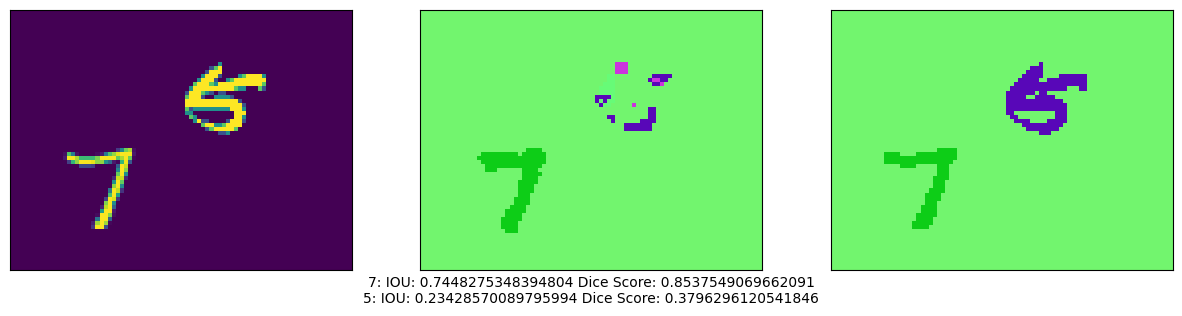

In [23]:
# place a number here between 0 to 191 to pick an image from the test set
integer_slider = 105

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image
  
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])  
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


### Compute IOU Score and Dice Score of the model

In [24]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
  average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

Digit 0: IOU: 0.669040279871357 Dice Score: 0.8017065710636102
Digit 1: IOU: 0.6786803418944265 Dice Score: 0.8085879425126541
Digit 2: IOU: 0.58793431629232 Dice Score: 0.7405020601419993
Digit 3: IOU: 0.3990976204551578 Dice Score: 0.5705071820868688
Digit 4: IOU: 0.4796324648091387 Dice Score: 0.64831297800837
Digit 5: IOU: 0.48671402198538016 Dice Score: 0.65475137085936
Digit 6: IOU: 0.6544364500546326 Dice Score: 0.791129148578686
Digit 7: IOU: 0.6095808374108072 Dice Score: 0.7574404754860115
Digit 8: IOU: 0.572012778821709 Dice Score: 0.7277457111391386
Digit 9: IOU: 0.5395195650144914 Dice Score: 0.7008934180182542

Grade is 56.76648676609421


## Save the Model

In [25]:
model.save("model.h5")